In [77]:
import torch
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split

In [78]:
# Check if device supports CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using: " + str(device))

using: cuda


Image information:

dimension: 300 x 300
bit depth: 24 bit (rgb : 3 x 8 bits)

In [79]:
def get_img_mean_std(loader) -> float:
    """
    Generates an approximation of the mean and std deviation for a given dataset of images.
    Approximations are much, much faster to calculate than exact values and shouldn't be too far off.

    :param loader: dataset to have calculated
    :return: mean, std deviation
    """

    mean = 0.
    std = 0.
    total_image_count = 0

    for imgs, _ in loader:
        batch_img_count = imgs.size(0)
        imgs = imgs.view(batch_img_count, imgs.size(1), -1)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        total_image_count += batch_img_count

    mean /= total_image_count
    std /= total_image_count

    return mean, std

In [80]:
# define transformation
initial_train_transform = transforms.Compose([
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

In [81]:
desired_batch_size = 4

In [82]:
# import dataset
original_train_dataset = datasets.ImageFolder("traindata", transform=initial_train_transform)

# create loader for generating mean/std deviation
full_train_loader = torch.utils.data.DataLoader(original_train_dataset, batch_size=desired_batch_size, shuffle=False, num_workers=2)

# show what classes have been identified
classes = original_train_dataset.classes
print("Classes:", classes)

Classes: ['cherry', 'strawberry', 'tomato']


In [83]:
# train_mean, train_std = get_img_mean_std(full_train_loader)
# print("mean: " + str(train_mean) + ", std: " + str(train_std))
# output: mean: tensor([0.5474, 0.4110, 0.3391]), std: tensor([0.2301, 0.2384, 0.2308])

# already calculated once so no need to do every time
train_mean = torch.tensor([0.5474, 0.4110, 0.3391])
train_std = torch.tensor([0.2301, 0.2384, 0.2308])

In [84]:
# define transformations
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

# used for validation dataset as well
test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

In [85]:
# set new transform
train_dataset = datasets.ImageFolder("traindata", transform=train_transform)

# create validation set for better training (and because I don't have the test set)
train_set, val_set = random_split(original_train_dataset, [3600, 900], generator=torch.Generator().manual_seed(7))
#                                                              ^ 3600, 900 = 80/20 split

# create loaders for train and val sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=desired_batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=desired_batch_size, shuffle=True, num_workers=2)

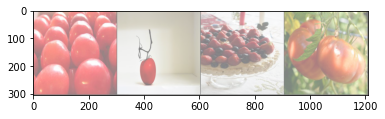

cherry tomato strawberry tomato


In [86]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(desired_batch_size)))

In [87]:
# define our CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=16, kernel_size=5)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=82944, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=400)
        self.fc3 = nn.Linear(in_features=400, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=50)
        self.fc5 = nn.Linear(in_features=50, out_features=3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

cnn_model = CNN()
cnn_model.to(device)

CNN(
  (conv1): Conv2d(3, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(30, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=82944, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=3, bias=True)
)

In [88]:
# define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.8)

In [ ]:
model_save_path = "model.pth"

In [89]:
# iterate over the dataset

min_valid_loss = np.inf
for epoch in range(30):
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    valid_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Forward Pass
        outputs = cnn_model(inputs)
        # Find the Loss
        loss = criterion(outputs, labels)
        # Calculate Loss
        valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: { train_loss / len(train_loader) } \t\t Validation Loss: { valid_loss / len(val_loader) }')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased { min_valid_loss } --> { valid_loss }')
        min_valid_loss = valid_loss
        torch.save(cnn_model.state_dict(), model_save_path)


print('Finished Training')

Epoch 1 		 Training Loss: 1.0991687668032117 		 Validation Loss: 4.335019011232588
Validation Loss Decreased inf --> 975.3792775273323
Epoch 2 		 Training Loss: 1.0875896665785048 		 Validation Loss: 4.408678997092776
Epoch 3 		 Training Loss: 1.0686754522720974 		 Validation Loss: 4.008350293901231
Validation Loss Decreased 975.3792775273323 --> 901.8788161277771
Epoch 4 		 Training Loss: 1.039417027036349 		 Validation Loss: 3.9799031527837117
Validation Loss Decreased 901.8788161277771 --> 895.4782093763351
Epoch 5 		 Training Loss: 1.014163492851787 		 Validation Loss: 4.199240455362532
Epoch 6 		 Training Loss: 0.9983573431107733 		 Validation Loss: 3.9074825411372713
Validation Loss Decreased 895.4782093763351 --> 879.1835717558861
Epoch 7 		 Training Loss: 0.9830959368083212 		 Validation Loss: 3.76152237839169
Validation Loss Decreased 879.1835717558861 --> 846.3425351381302
Epoch 8 		 Training Loss: 0.9758986341622141 		 Validation Loss: 4.1104105559984845
Epoch 9 		 Training 

In [90]:
# save the trained model

#torch.save(cnn_model.state_dict(), model_save_path)

Now for testing

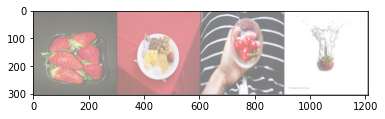

strawberry strawberry cherry strawberry


In [91]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(desired_batch_size)))

In [92]:
# load the model from file
cnn_model = CNN()
cnn_model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [93]:
outputs = cnn_model(images)

In [94]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(desired_batch_size)))

Predicted:  cherry strawberry strawberry strawberry


In [95]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 900 validation images: {100 * correct // total} %')

Accuracy of the network on the 900 validation images: 48 %


In [96]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = cnn_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cherry is 49.5 %
Accuracy for class: strawberry is 37.2 %
Accuracy for class: tomato is 59.9 %


When the images are normalised Cherry and tomato have good accuracy but strawberry is extremely low.

When the images are not normalised cherry and tomato have less accuracy but strawberry has good accuracy

with 30 epochs accuracies are around 50-60%

In [97]:
# clean up
del dataiter